# Fine-tuning Florence-2 on DocVQA

In this notebook, we will fine-tune Florence-2 by MSFT, a new vision language model capable of various tasks, on document question answering.

Let's start by installing the dependencies and loading the dataset.

In [1]:
# from datasets import load_dataset

# data = load_dataset("HuggingFaceM4/DocumentVQA")


import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# Load the CSV files
train_df = pd.read_csv('train.csv')[:5000]
test_df = pd.read_csv('test.csv')

D:\CONDA\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Split the train data into train (90%), validation (5%), and test (5%) sets
train_data, temp_data = train_test_split(train_df, test_size=0.1, random_state=42)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Convert pandas DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_data)
validation_dataset = Dataset.from_pandas(validation_data)
test_dataset = Dataset.from_pandas(test_data)
prediction_dataset = Dataset.from_pandas(test_df)



# Create a DatasetDict with the required structure
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset,
    'prediction': prediction_dataset
})

# Check the structure
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['image_link', 'group_id', 'entity_name', 'entity_value', '__index_level_0__'],
        num_rows: 4500
    })
    validation: Dataset({
        features: ['image_link', 'group_id', 'entity_name', 'entity_value', '__index_level_0__'],
        num_rows: 250
    })
    test: Dataset({
        features: ['image_link', 'group_id', 'entity_name', 'entity_value', '__index_level_0__'],
        num_rows: 250
    })
    prediction: Dataset({
        features: ['index', 'image_link', 'group_id', 'entity_name'],
        num_rows: 131187
    })
})


We can load the model using `AutoModelForCausalLM` and the processor using `AutoProcessor`  classes of transformers library. Note that we need to pass `trust_remote_code` as `True` since this model is not a transformers model.

In [3]:
from transformers import AutoModelForCausalLM, AutoConfig ,AutoProcessor
import torch

# Load config first
config = AutoConfig.from_pretrained("smishah774/Florence-2-FT-amazone", trust_remote_code=True)

# Ensure the vision model type is DaViT
if config.vision_config.model_type != 'davit':
    config.vision_config.model_type = 'davit'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Now load the model with updated config
model = AutoModelForCausalLM.from_pretrained("smishah774/Florence-2-FT-amazone", config=config, trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("smishah774/Florence-2-FT-amazone", trust_remote_code=True)


In [4]:
import requests
from PIL import Image
from io import BytesIO

def url_to_png_image(url):
    # Download the image from the URL
    response = requests.get(url)
    response.raise_for_status()  # Check for any request errors

    # Convert the downloaded content to an image
    img = Image.open(BytesIO(response.content))

    # Convert the image to PNG format if it's not already
    if img.format != 'PNG':
        img = img.convert('RGBA')  # Convert to a format that can be saved as PNG

    # Save the image in PNG format (in memory)
    png_image = BytesIO()
    img.save(png_image, format='PNG')

    # Reopen as a PNGImageFile object
    png_image.seek(0)  # Rewind the file-like object
    png_img = Image.open(png_image)

    return png_img

# Example usage
url = "https://m.media-amazon.com/images/I/81eR2ao4H-L.jpg"
png_image = url_to_png_image(url)
print(type(png_image))  # Should print: <class 'PIL.PngImagePlugin.PngImageFile'>

<class 'PIL.PngImagePlugin.PngImageFile'>


In [5]:
torch.cuda.empty_cache()

Let's do inference with our dataset first to see how the model performs already with our dataset before fine-tuning.

In [6]:
# Function to run the model on an example
def run_example(task_prompt, text_input, image):
    prompt = task_prompt + text_input

    # Ensure the image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
    return parsed_answer


{'<FETCH>': '14.7 gram'}
item_weight
14.7 gram


C:\Users\Achyut\.cache\huggingface\modules\transformers_modules\microsoft\Florence-2-base-ft\9803f52844ec1ae5df004e6089262e9a23e527fd\modeling_florence2.py:1209: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


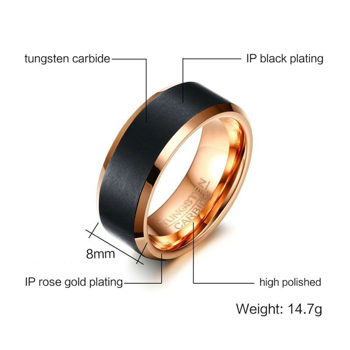

{'<FETCH>': '454.5 gram'}
item_weight
454 gram


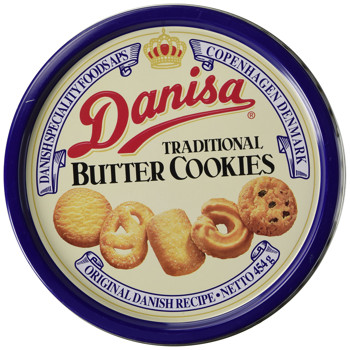

{'<FETCH>': '2.2 kilogram'}
item_weight
2.2 pound


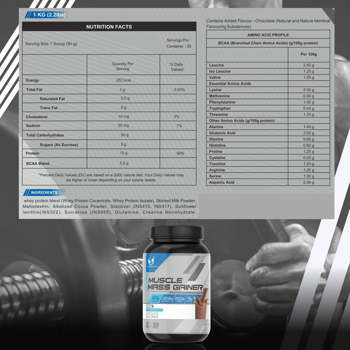

{'<FETCH>': '9.4 gram'}
item_weight
9.4 gram


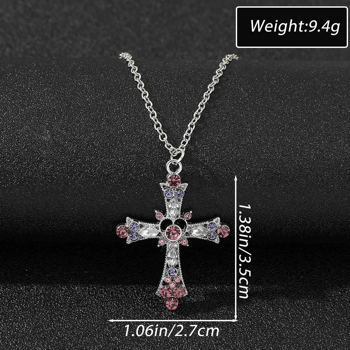

In [7]:
for idx in range(12,16):
  img = url_to_png_image(dataset_dict['train'][idx]['image_link'])
  print(run_example("<FETCH>", dataset_dict['train'][idx]['entity_name'], img))
  print(dataset_dict['train'][idx]['entity_name'])
  print(dataset_dict['train'][idx]['entity_value'])
  display(img.resize([350, 350]))

We need to construct our dataset. Note how we are adding a new task prefix `<DocVQA>` before the question when constructing the prompt.

In [8]:
from torch.utils.data import Dataset
import random

class DocVQADataset(Dataset):
    def __init__(self, data):  # Corrected __init__ method
        self.data = data

    def __len__(self):  # Corrected __len__ method
        return len(self.data)

    def __getitem__(self, idx):  # Corrected __getitem__ method
        example = self.data[idx]
        question = "<FETCH>" + example['entity_name']
        first_answer = example['entity_value']
        try:
            image = url_to_png_image(example['image_link'])
        except:
            image = url_to_png_image('https://m.media-amazon.com/images/I/61Kw39i4-gL.jpg')
            question = "<FETCH>" + "item_weight"
            first_answer = "30.0 gram"

        if image.mode != "RGB":
            image = image.convert("RGB")
        return question, first_answer, image


Let's get to fine-tuning. We will create our dataset, the data collator, and start training. In A100 with 40GB memory, we can fit in 6 examples. If you're training on T4, you can use batch size of 1.

In [9]:
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (AdamW, AutoProcessor, get_scheduler)

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(device)
    return inputs, answers

# Create datasets
train_dataset = DocVQADataset(dataset_dict['train'])
val_dataset = DocVQADataset(dataset_dict['validation'])

# Create DataLoader
batch_size = 1
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers)

In [10]:
def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        i = -1
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            i += 1
            inputs, answers = batch

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                inputs, answers = batch

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Average Validation Loss: {avg_val_loss}")

        # Save model checkpoint
        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)


After training, we will push the model to Hugging Face Hub. To do so, we need to login first with write access. Make sure to pass either write token or fine-grained token (by first creating the repository and setting up fine-grained token access).

We will freeze image encoder for this tutorial. The authors have reported improvement in unfreezing image encoder, but note that this will result in more resource usage.

In [11]:
for param in model.vision_tower.parameters():
  param.is_trainable = False

In [12]:
train_model(train_loader, val_loader, model, processor, epochs=1)

D:\CONDA\envs\myenv\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1/1: 100%|████████████████████████████████████████████████████████| 4500/4500 [3:20:24<00:00,  2.67s/it]


Average Training Loss: 0.6395555835301057


Validation Epoch 1/1: 100%|██████████████████████████████████████████████████████████| 250/250 [03:55<00:00,  1.06it/s]


Average Validation Loss: 0.5449426784962416


You can push the model like below. You can find the fully fine-tuned DocVQA model [here](https://huggingface.co/HuggingFaceM4/Florence-2-DocVQA). You can find the demo [here](https://huggingface.co/spaces/andito/Florence-2-DocVQA).

Read more about Florence-2 and fine-tuning it [here](https://huggingface.co/blog/finetune-florence2).

In [13]:
test_df['prediction'] = None

In [14]:
test_df.shape

(131187, 5)

In [15]:
from IPython.display import clear_output

for idx in range(len(test_df)):
  if idx % 10 == 0:
    test_df.to_csv('submission.csv')
    clear_output(wait=True)
    print(idx/131187,end=' ')

  try:
    img = url_to_png_image(test_df.iloc[idx,1])
    ans = run_example("<FETCH>", test_df.iloc[idx,3], img)
    test_df.iloc[idx,4] = ans['<FETCH>']
  except:
    test_df.iloc[idx,4] = None

0.13880948569599122 


KeyboardInterrupt



In [18]:
# Define the directory where the model and processor will be saved
save_directory = "D:/logical/fine_tuned_model"

# Save the model's weights and configuration
model.save_pretrained(save_directory)

# Save the processor
processor.save_pretrained(save_directory)

[]